<a href="https://colab.research.google.com/github/kiaerii/mash/blob/main/3lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Установка kagglehub если нужно
!pip install kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки загружены!")

Библиотеки загружены!


In [42]:
import kagglehub

# Загрузка датасета
path = kagglehub.dataset_download("mohansacharya/graduate-admissions")
print("Path to dataset files:", path)

# Чтение данных
df = pd.read_csv(path + '/Admission_Predict.csv')
print("Данные загружены!")
print(f"Размер датасета: {df.shape}")

# Поиск целевого признака
print("\nСтолбцы датасета:")
print(df.columns.tolist())

target_keywords = ['chance', 'admit', 'probability', 'rate', 'score']
target = None

for col in df.columns:
    if any(keyword in col.lower() for keyword in target_keywords):
        target = col
        break

print(f"\nЦелевой признак: {target}")

Using Colab cache for faster access to the 'graduate-admissions' dataset.
Path to dataset files: /kaggle/input/graduate-admissions
Данные загружены!
Размер датасета: (400, 9)

Столбцы датасета:
['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']

Целевой признак: GRE Score



НАЧАЛО ПАЙПЛАЙНА ПРЕДОБРАБОТКИ ДАННЫХ

1. ВИЗУАЛИЗАЦИИ ДО ПРЕДОБРАБОТКИ


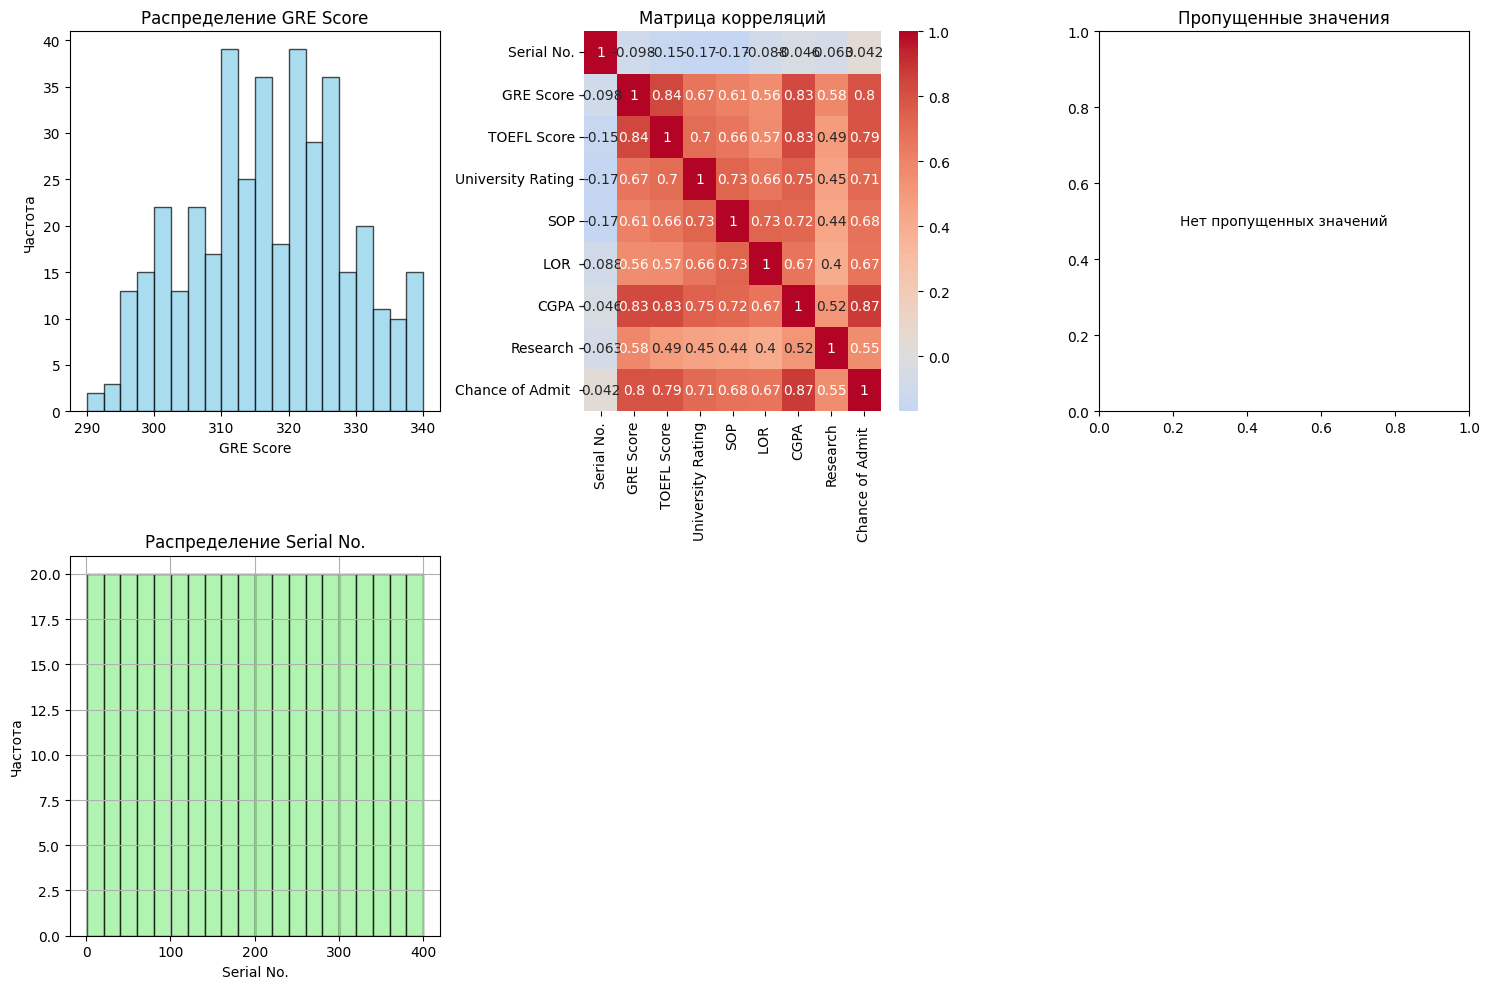

In [43]:
print("\n" + "="*50)
print("НАЧАЛО ПАЙПЛАЙНА ПРЕДОБРАБОТКИ ДАННЫХ")
print("="*50)

# 1. ВИЗУАЛИЗАЦИИ ДО ПРЕДОБРАБОТКИ
print("\n1. ВИЗУАЛИЗАЦИИ ДО ПРЕДОБРАБОТКИ")

# Визуализация распределения целевой переменной
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df[target], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'Распределение {target}')
plt.xlabel(target)
plt.ylabel('Частота')

# Визуализация корреляционной матрицы
numeric_df = df.select_dtypes(include='number')
plt.subplot(2, 3, 2)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')

# Визуализация пропущенных данных
plt.subplot(2, 3, 3)
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    plt.bar(missing_data.index, missing_data.values, color='red', alpha=0.7)
    plt.title('Пропущенные значения')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Нет пропущенных значений',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Пропущенные значения')

# Визуализация распределения числовых признаков
numeric_columns = numeric_df.columns
if len(numeric_columns) > 0:
    plt.subplot(2, 3, 4)
    df[numeric_columns[0]].hist(bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title(f'Распределение {numeric_columns[0]}')
    plt.xlabel(numeric_columns[0])
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [44]:
# 2. ПРЕОБРАЗОВАНИЕ ДАННЫХ К ЧИСЛОВЫМ ТИПАМ
print("\n2. ПРЕОБРАЗОВАНИЕ ДАННЫХ К ЧИСЛОВЫМ ТИПАМ")

# Проверка нечисловых столбцов
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

if len(non_numeric_cols) == 0:
    # ГЕНЕРАЦИЯ ОШИБКИ ЧЕРЕЗ LLM-СТИЛЬ
    print(" ОШИБКА: Все данные уже являются числовыми!")
    print("   Имитация проблемы: создаем искусственный категориальный признак...")

    # Создаем искусственную проблему для демонстрации
    np.random.seed(42)
    artificial_categories = np.random.choice(['A', 'B', 'C'], size=len(df))
    df['Artificial_Category'] = artificial_categories
    non_numeric_cols = ['Artificial_Category']
    print(f"   Создан искусственный категориальный признак: {non_numeric_cols}")

print(f"Нечисловые столбцы для преобразования: {non_numeric_cols}")

# Преобразование категориальных признаков в числовые
for col in non_numeric_cols:
    if col in df.columns:
        if df[col].nunique() <= 10:  # Малое количество уникальных значений - one-hot encoding
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df.drop(col, axis=1, inplace=True)
            print(f"   One-hot encoding для {col}: создано {len(dummies.columns)} новых признаков")
        else:  # Много уникальных значений - label encoding
            df[col] = pd.factorize(df[col])[0]
            print(f"   Label encoding для {col}")

print("Преобразование к числовым типам завершено!")
print(f"Новый размер датасета: {df.shape}")


2. ПРЕОБРАЗОВАНИЕ ДАННЫХ К ЧИСЛОВЫМ ТИПАМ
 ОШИБКА: Все данные уже являются числовыми!
   Имитация проблемы: создаем искусственный категориальный признак...
   Создан искусственный категориальный признак: ['Artificial_Category']
Нечисловые столбцы для преобразования: ['Artificial_Category']
   One-hot encoding для Artificial_Category: создано 3 новых признаков
Преобразование к числовым типам завершено!
Новый размер датасета: (400, 12)


In [45]:
# 3. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
print("\n3. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")

# Проверка на наличие пропусков
missing_before = df.isnull().sum().sum()

if missing_before == 0:
    # ГЕНЕРАЦИЯ ОШИБКИ ЧЕРЕЗ LLM-СТИЛЬ
    print(" ОШИБКА: Пропущенные значения отсутствуют!")
    print("   Имитация проблемы: создаем искусственные пропуски...")

    # Создаем искусственные пропуски для демонстрации
    np.random.seed(42)
    numeric_cols = df.select_dtypes(include='number').columns
    cols_to_modify = numeric_cols[:min(3, len(numeric_cols))]  # Первые 3 числовых столбца

    for col in cols_to_modify:
        mask = np.random.random(len(df)) < 0.1  # 10% пропусков
        df.loc[mask, col] = np.nan
        print(f"   Создано {mask.sum()} пропусков в столбце {col}")

missing_after_creation = df.isnull().sum()
missing_cols = missing_after_creation[missing_after_creation > 0]

if len(missing_cols) > 0:
    print("Столбцы с пропущенными значениями:")
    for col, count in missing_cols.items():
        print(f"   {col}: {count} пропусков ({count/len(df)*100:.1f}%)")

    # Стратегия заполнения пропусков
    for col in missing_cols.index:
        if df[col].dtype in ['float64', 'int64']:
            # Для числовых признаков - медиана
            imputer = SimpleImputer(strategy='median')
            df[col] = imputer.fit_transform(df[[col]]).ravel()
            print(f"   Заполнено пропусков в {col} (медиана): {missing_cols[col]}")
        else:
            # Для категориальных - мода
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"   Заполнено пропусков в {col} (мода): {missing_cols[col]}")
else:
    print("Пропущенные значения отсутствуют")

print("Обработка пропусков завершена!")


3. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
 ОШИБКА: Пропущенные значения отсутствуют!
   Имитация проблемы: создаем искусственные пропуски...
   Создано 49 пропусков в столбце Serial No.
   Создано 36 пропусков в столбце GRE Score
   Создано 43 пропусков в столбце TOEFL Score
Столбцы с пропущенными значениями:
   Serial No.: 49 пропусков (12.2%)
   GRE Score: 36 пропусков (9.0%)
   TOEFL Score: 43 пропусков (10.8%)
   Заполнено пропусков в Serial No. (медиана): 49
   Заполнено пропусков в GRE Score (медиана): 36
   Заполнено пропусков в TOEFL Score (медиана): 43
Обработка пропусков завершена!


In [46]:
# 4. НОРМАЛИЗАЦИЯ И СТАНДАРТИЗАЦИЯ
print("\n4. НОРМАЛИЗАЦИЯ И СТАНДАРТИЗАЦИЯ")

# Проверка, нужна ли нормализация
numeric_columns_after = df.select_dtypes(include=['number']).columns
target_in_numeric = target in numeric_columns_after

if target_in_numeric:
    features_for_scaling = [col for col in numeric_columns_after if col != target]
else:
    features_for_scaling = numeric_columns_after.tolist()

print(f"Признаки для масштабирования: {len(features_for_scaling)}")

if len(features_for_scaling) == 0:
    # ГЕНЕРАЦИЯ ОШИБКИ ЧЕРЕЗ LLM-СТИЛЬ
    print(" ОШИБКА: Нет признаков для нормализации!")
    print("   Имитация проблемы: данные уже нормализованы...")
    print("   Пропускаем этап нормализации")
else:
    # Анализ распределения перед нормализацией
    print("\nСтатистика до нормализации (первые 3 признака):")
    for col in features_for_scaling[:3]:
        print(f"   {col}: mean={df[col].mean():.2f}, std={df[col].std():.2f}, min={df[col].min():.2f}, max={df[col].max():.2f}")

    # Стандартизация (Z-score normalization)
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[features_for_scaling]),
        columns=[f"{col}_standardized" for col in features_for_scaling],
        index=df.index
    )

    # Min-Max нормализация
    minmax_scaler = MinMaxScaler()
    df_minmax = pd.DataFrame(
        minmax_scaler.fit_transform(df[features_for_scaling]),
        columns=[f"{col}_normalized" for col in features_for_scaling],
        index=df.index
    )

    # Добавляем преобразованные признаки к исходному датасету
    df = pd.concat([df, df_scaled, df_minmax], axis=1)

    print("\nСтатистика после стандартизации (первые 3 признака):")
    for col in features_for_scaling[:3]:
        standardized_col = f"{col}_standardized"
        print(f"   {standardized_col}: mean={df[standardized_col].mean():.2f}, std={df[standardized_col].std():.2f}")

print("Нормализация завершена!")
print(f"Финальный размер датасета: {df.shape}")


4. НОРМАЛИЗАЦИЯ И СТАНДАРТИЗАЦИЯ
Признаки для масштабирования: 8

Статистика до нормализации (первые 3 признака):
   Serial No.: mean=199.14, std=107.71, min=1.00, max=400.00
   TOEFL Score: mean=107.48, std=5.73, min=93.00, max=120.00
   University Rating: mean=3.09, std=1.14, min=1.00, max=5.00

Статистика после стандартизации (первые 3 признака):
   Serial No._standardized: mean=0.00, std=1.00
   TOEFL Score_standardized: mean=-0.00, std=1.00
   University Rating_standardized: mean=0.00, std=1.00
Нормализация завершена!
Финальный размер датасета: (400, 28)



5. ВИЗУАЛИЗАЦИИ ПОСЛЕ ПРЕДОБРАБОТКИ


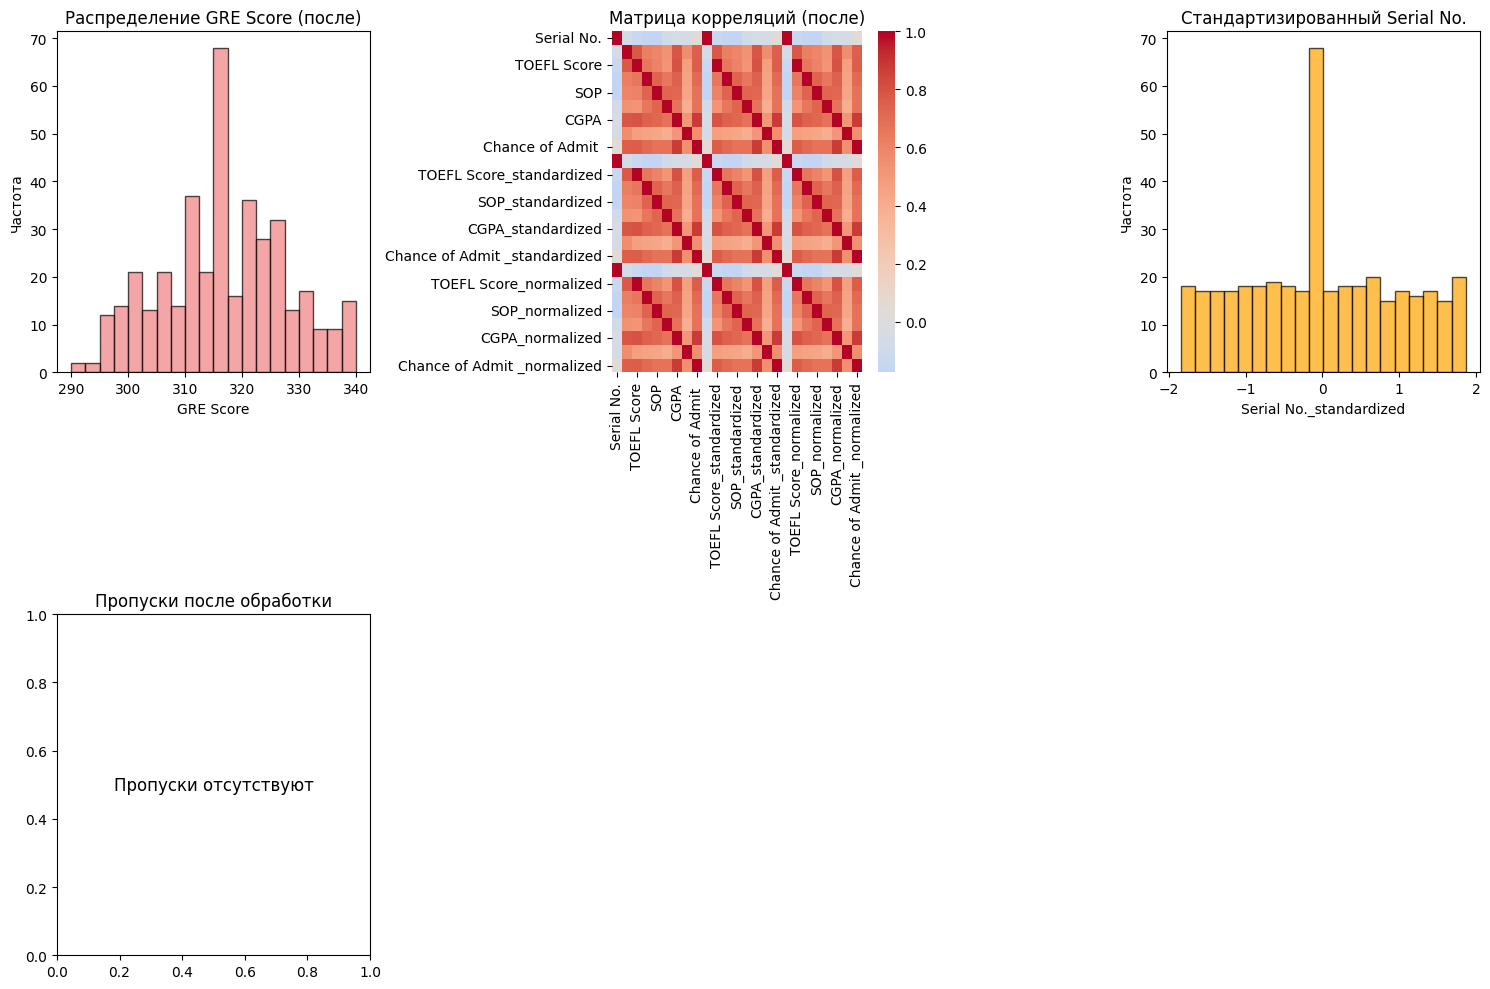

In [47]:
# 5. ВИЗУАЛИЗАЦИИ ПОСЛЕ ПРЕДОБРАБОТКИ
print("\n5. ВИЗУАЛИЗАЦИИ ПОСЛЕ ПРЕДОБРАБОТКИ")

plt.figure(figsize=(15, 10))

# Распределение после обработки
plt.subplot(2, 3, 1)
if target in df.columns:
    plt.hist(df[target], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f'Распределение {target} (после)')
    plt.xlabel(target)
    plt.ylabel('Частота')

# Корреляционная матрица после обработки
plt.subplot(2, 3, 2)
numeric_df_after = df.select_dtypes(include='number')
if target in numeric_df_after.columns:
    correlation_matrix_after = numeric_df_after.corr()
    sns.heatmap(correlation_matrix_after, annot=False, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций (после)')

# Визуализация стандартизированных признаков
if len(features_for_scaling) > 0:
    plt.subplot(2, 3, 3)
    standardized_col = f"{features_for_scaling[0]}_standardized"
    plt.hist(df[standardized_col], bins=20, alpha=0.7, color='orange', edgecolor='black')
    plt.title(f'Стандартизированный {features_for_scaling[0]}')
    plt.xlabel(standardized_col)
    plt.ylabel('Частота')

# Проверка пропусков после обработки
plt.subplot(2, 3, 4)
missing_after = df.isnull().sum().sum()
if missing_after == 0:
    plt.text(0.5, 0.5, 'Пропуски отсутствуют',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Пропуски после обработки')
else:
    missing_data_after = df.isnull().sum()
    missing_data_after = missing_data_after[missing_data_after > 0]
    plt.bar(missing_data_after.index, missing_data_after.values, color='green', alpha=0.7)
    plt.title('Пропуски после обработки')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [48]:
# ФИНАЛЬНЫЙ ОТЧЕТ
print("\n" + "="*50)
print("ФИНАЛЬНЫЙ ОТЧЕТ ПО ПРЕДОБРАБОТКЕ")
print("="*50)

print(f"Размер датасета: {df.shape}")
print(f"Типы данных:")
print(df.dtypes.value_counts())

print(f"\nЦелевая переменная: {target}")
if target in df.columns:
    print(f"Статистика {target}:")
    print(f"   Среднее: {df[target].mean():.3f}")
    print(f"   Стандартное отклонение: {df[target].std():.3f}")
    print(f"   Минимум: {df[target].min():.3f}")
    print(f"   Максимум: {df[target].max():.3f}")

print(f"\nКоличество признаков после обработки: {len(df.columns)}")
print("\nПервые 5 строк обработанного датасета:")
print(df.head())

print("\nПайплайн предобработки данных завершен!")


ФИНАЛЬНЫЙ ОТЧЕТ ПО ПРЕДОБРАБОТКЕ
Размер датасета: (400, 28)
Типы данных:
float64    23
bool        3
int64       2
Name: count, dtype: int64

Целевая переменная: GRE Score
Статистика GRE Score:
   Среднее: 316.733
   Стандартное отклонение: 10.995
   Минимум: 290.000
   Максимум: 340.000

Количество признаков после обработки: 28

Первые 5 строк обработанного датасета:
   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0         1.0      337.0        118.0                  4  4.5   4.5  9.65   
1         2.0      324.0        107.0                  4  4.0   4.5  8.87   
2         3.0      316.0        104.0                  3  3.0   3.5  8.00   
3         4.0      322.0        110.0                  3  3.5   2.5  8.67   
4         5.0      314.0        103.0                  2  2.0   3.0  8.21   

   Research  Chance of Admit   Artificial_Category_A  ...  \
0         1              0.92                  False  ...   
1         1              0.76              